# Model Explainers
*A way to understand the 'black box'*

In a typical decision tree, adding additional features can increase branching and time required to train the model. It can often be helpful to understand what the model is finding the greatest correlation between feature and target, so we don't waste resources on calculating insignificant features, or we can find similar features to the high importance features to increase model accuracy.

There are ways to determine model importance manually (such as dropping each column in turn and re-training the model and evaluating importance) but these systems are resource intensive and computationally expensive.  
Also, using a manual method, we can't look at individual predictions, and understand how each value of each feature effects the final predicted output. Using model explainers can help us understand the way feature values effect individual observations.

In this notebook, we'll be looking at two popular model explainers.

One model explainer is SHAP (SHapley Additive exPlanations). The amazing thing about SHAP is that it can explain a model of any type, descision tree, neural network, etc.   
Another popular model explainer is DALEX, which is nice because it's available in both R and Python

### Read in Dataset

In [0]:
from pyspark.sql.functions import col

# Create a dataset from our data. We'll use some of our features we've created
dftar = spark.read.table("model.targets")
dftar = dftar.drop("region","n_subway","n_mcdonalds")
df_1 = spark.read.table("model.black_income_and_distance")
df_1 = df_1.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code")
df_3 = spark.read.table("model.bblignaut_average_weekly_vistor_difference")
df_3 = df_3.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code")
df_4 = spark.read.table("model.brandon_new_bus_2_year")
df_4 = df_4.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code")
df_5 = spark.read.table("model.spencer_guo_count_bigger_places_by_tract")
df_5 = df_5.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code")
df_6 = spark.read.table("model.spencer_w_similarbusinesscount")
df_6 = df_6.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code")
df_7 = spark.read.table("model.schultz_dwell_time")
df_7 = df_7.drop("region","n_lsRestaurants","n_subway","n_mcdonalds","naics_code","total_visits")

# Join everything up
df = dftar.join(df_1,["tract"],'left')
df = df.join(df_3,["tract"],'left')
df = df.join(df_4,["tract"],'left')
df = df.join(df_5,["tract"],'left')
df = df.join(df_6,["tract"],'left')
df = df.join(df_7,["tract"],'left')

# Some columns saved a strings. We can't have that in an ML model. Cast all columns to numbers
df = df.select([col(c).cast("int") for c in df.columns])

# ML model can't handle NA values
df = df.fillna(0)

# Display the dataset so we can see what we're working with
display(df)

tract,n_lsRestaurants,avg_dist_from_home,median_dist_from_home,total_visits,min_dist_from_home,max_dist_from_home,sd_dist_from_home,avg_income,average_weekly_vistor_difference,count_new_bus_past_year,total_businesses,average_visitors,new_business_proportion,count_bigger_places_by_tract,count_bigger_places_by_tract_2,Arts/Sports,Gas Stations,Health,Hotel,Movie,Transport,avg_dwell_time,min_dwell_time,max_dwell_time,sd_dwell_time
0,1,84249,65902,349,415,349355,93221,31403,0,1,8532,15,0,0,0,0,4,0,5,0,1,26,10,165,21
0,12,17496,15904,5250,10826,30710,5572,42311,0,31,29423,25,0,1,1,0,5,23,17,0,0,14,8,23,3
0,9,4441,4438,9880,4055,4964,280,45902,0,7,14142,43,0,1,1,0,1,6,1,2,0,11,9,19,2
0,11,224883,235352,9922,70532,343563,63656,35429,0,21,28293,29,0,3,3,0,12,9,11,0,4,15,10,30,3
0,5,5330,5225,2341,4313,7777,963,34457,0,12,10653,19,0,0,0,0,0,17,1,0,0,21,12,37,5
0,5,23125,12079,4923,3618,87129,24935,45310,0,12,14049,25,0,0,0,0,6,10,11,0,4,10,7,19,1
0,3,10921,7616,1107,4096,39087,9357,45134,0,6,9912,15,0,0,0,0,5,1,7,0,1,15,6,49,6
0,17,5706,5233,16578,4761,8596,1187,39587,0,16,23791,55,0,2,2,0,7,7,12,0,0,11,8,15,1
0,3,107621,103029,1642,49226,221868,52852,55891,0,12,11467,30,0,2,2,0,9,14,8,1,1,20,9,101,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,177,4,1283,218


## Create and train a machine learning model
We'll be using XGBoost

In [0]:
import xgboost
import numpy as np

# XBBoost plays nicer with Pandas. Because our dataset is relatively small, we can convert to Pandas
pdf = df.toPandas()

# Create the features and target
X = pdf.drop("n_lsRestaurants",1)
y = pdf["n_lsRestaurants"]

# Set up the model
Xd = xgboost.DMatrix(X, label=y)

# Train the model. We'll make it fairly small to reduce computation time
model = xgboost.train({
    'max_depth':10, 'base_score': 0.5, "lambda": 1
}, Xd)

# Get the predictions
pred = model.predict(Xd, output_margin=True)

## Built In 'Model Explainer'
Most models have a built in 'feature importance' that you can use. However, these tend to be ugly and only contained summarized information

Out[5]:

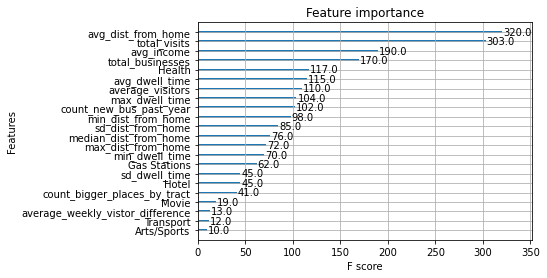

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [0]:
from xgboost import plot_importance

# Ew. Gross. Hard to interpret. Only contains summarized, high-level data
plot_importance(model)

## SHAP
SHAP has the ability to show the same model summaries that the built in feature importance functions can show. However, the real power of model explainers comes in with the ability to show each individual observation. 

Just some things to note: In this training we'll be using SHAP's TreeExplainer. This works with any type of tree based model (gradient boosted, random forest, light boost, etc). SHAP also includes a KernelExplainer, which can be used for KNN, neural networks, or any other types of models. The KernelExplainer has some limitations compared to the TreeExplainer. For one, it simulates missing features by random sampling, instead of just looking at a tree's decision path. It also takes *much* longer to run (as a result of it being model agnostic) and there are some visualization limitations.

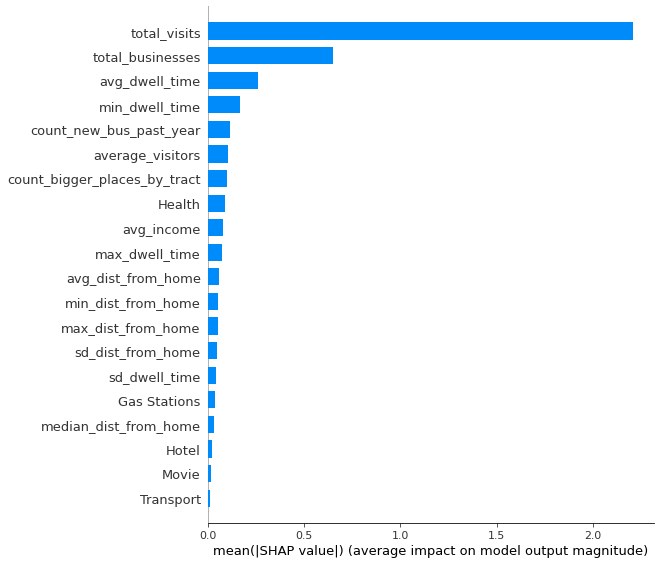

In [0]:
import shap

# We start by getting the explainer and shap values. You'll need to do this once per model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)

# Let's start just by displaying the same graph as the built in one, just 'SHAP'-ified. 
# This is what we call a global explanation. But this isn't all SHAP is good for
shap.summary_plot(shap_values, X, plot_type="bar")

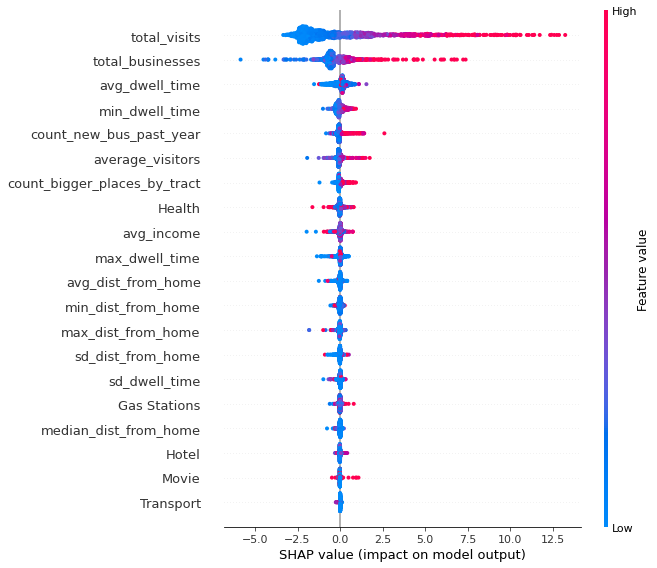

In [0]:
# Notice that the only difference in code between this and the previous plot is 'plot_type'
shap.summary_plot(shap_values, X)

Notice how there are a bunch of dots in the previous plot. Each dot is an observation. The color indicates the value of the feature itself. The y-axis is the feature, but the x-axis is the SHAP value, which is the magic sauce to SHAP.
The Shap value is the average marginal contribution of a feature value across all possible coalitions. (How much each feature in a model has contributed to the prediction).
The summary plot combines feature importance with feature effects. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance. You can tell that having a really high total_visits has a massive correlation to predicting a high n_IsRestaurants.

Now we can get into local explanations, and understandting individual observations

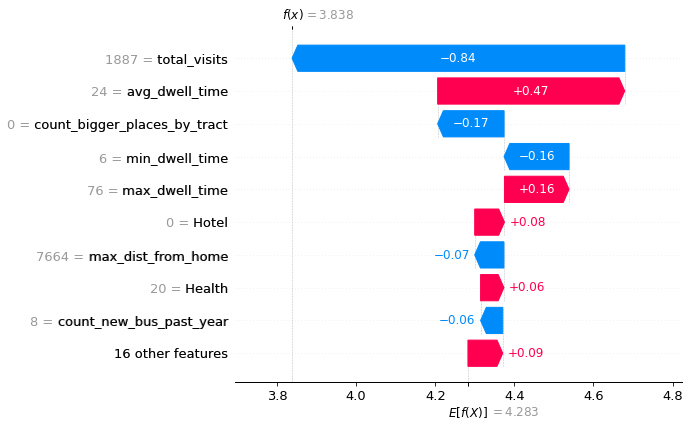

In [0]:
# We need to reset our explainer for local explanations
shap_values = explainer(X)
shap.plots.waterfall(shap_values[600])

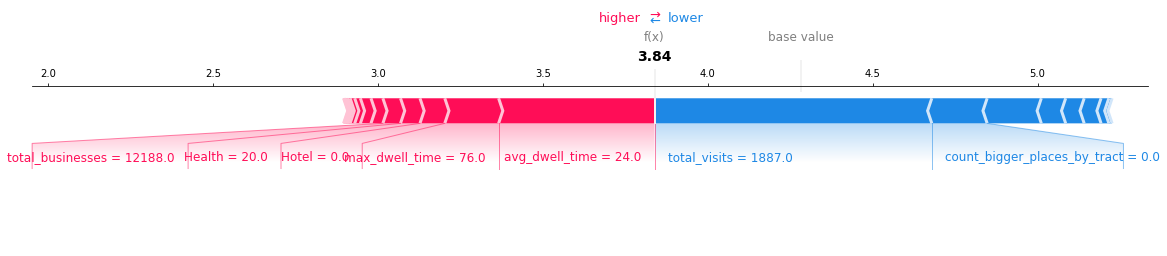

In [0]:
# This plot requires a workaround to work in Databricks
force_display = shap.plots.force(shap_values[600],matplotlib=True)
display(force_display)

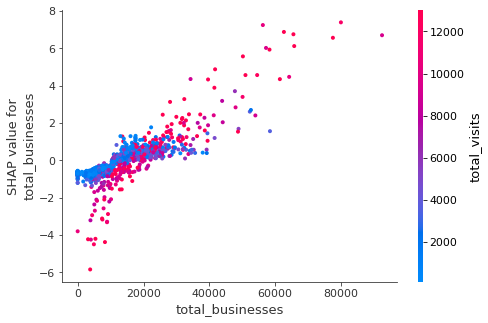

In [0]:
shap_values = explainer.shap_values(X)
shap.dependence_plot(10, shap_values, X)

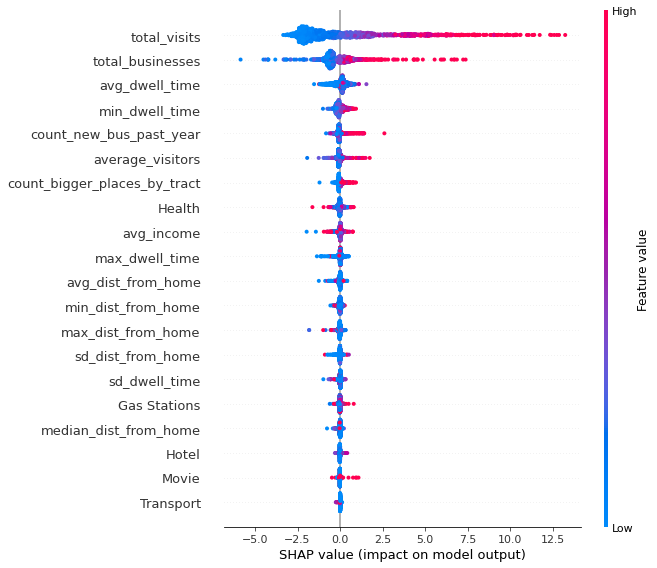

In [0]:
# Summary plot to show impact on model
shap.summary_plot(shap_values, X)

## Dalex

Dalex is another package you can use to explain your macine learning model. It is actually very similar to Shap. You can use Dalex to check the importance of each feature, and how each feature contributes to the final prediction.

In [0]:
#pip install dalex

Python interpreter will be restarted.
Collecting dalex
 Downloading dalex-1.4.1.tar.gz (1.0 MB)
Requirement already satisfied: setuptools in /usr/local/lib/python3.8/dist-packages (from dalex) (52.0.0)
Requirement already satisfied: pandas>=1.1.2 in /databricks/python3/lib/python3.8/site-packages (from dalex) (1.2.4)
Requirement already satisfied: numpy>=1.18.4 in /databricks/python3/lib/python3.8/site-packages (from dalex) (1.19.2)
Requirement already satisfied: plotly>=4.12.0 in /databricks/python3/lib/python3.8/site-packages (from dalex) (5.3.1)
Requirement already satisfied: tqdm>=4.48.2 in /databricks/python3/lib/python3.8/site-packages (from dalex) (4.59.0)
Requirement already satisfied: scipy>=1.5.4 in /databricks/python3/lib/python3.8/site-packages (from dalex) (1.6.2)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.1.2->dalex) (2020.5)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=1.1.2->dalex) (2.8.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly>=4.12.0->dalex) (1.15.0)
Requirement already satisfied: tenacity>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from plotly>=4.12.0->dalex) (6.2.0)
Building wheels for collected packages: dalex
 Building wheel for dalex (setup.py): started
 Building wheel for dalex (setup.py): finished with status 'done'
 Created wheel for dalex: filename=dalex-1.4.1-py3-none-any.whl size=1042840 sha256=1708660116d05633911ece3f542965f817a8caecbb560de096b32a7b199754ed
 Stored in directory: /root/.cache/pip/wheels/04/44/bc/0d840d8c133c3a50823bf9a05c99c33a678a5b8f1fa7f09d77
Successfully built dalex
Installing collected packages: dalex
Successfully installed dalex-1.4.1
Python interpreter will be restarted.

In [0]:
import dalex as dx
dalex_explainer = dx.Explainer(model, X, y)

Preparation of a new explainer is initiated

 -> data : 1528 rows 25 cols
 -> target variable : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
 -> target variable : 1528 values
 -> model_class : xgboost.core.Booster (default)
 -> label : Not specified, model's class short name will be used. (default)
 -> predict function : <function yhat_xgboost at 0x7fe0e4178b80> will be used (default)
 -> predict function : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
 -> predicted values : min = 0.905, mean = 4.28, max = 29.4
 -> model type : 'model_type' not provided and cannot be extracted.
 -> model type : Some functionalities won't be available.
 -> residual function : difference between y and yhat (default)
 -> residuals : min = -0.69, mean = 0.175, max = 7.63
 -> model_info : package xgboost

A new explainer has been created!

In [0]:
# Here we can see the importance of each feature
dalex_explainer.model_parts().plot()

In [0]:
# select all variables from the POI
exl = X.iloc[17]

# Here we are predicting the the number of restaurants for tract # 17 from our table. It is interactive and similar to shap. The green bar means the how much that feature increases in the final restult, and the red bar means how much that feature decreases in the final results.
dalex_explainer.predict_parts(exl).plot()

##Model-level explanations
This function calculates various Model Performance measures:

classification: F1, accuracy, recall, precision and AUC
regression: mean squared error, R squared, median absolute deviation

In [0]:
mp = dalex_explainer.model_performance(model_type = 'regression')
mp.result

Out[11]:

,mse,rmse,r2,mae,mad
Booster,0.239259,0.489141,0.986857,0.268219,0.13894


##ROC
In a Receiver Operating Characteristic (ROC) curve the true positive rate (Sensitivity) is plotted in function of the false positive rate (100-Specificity) for different cut-off points. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test.

The ROC curve is a fundamental tool for diagnostic test evaluation.
Most ROC curve plots obscure the cutoff values and inhibit interpretation and comparison of multiple curves. This attempts to address those shortcomings by providing plotting and interactive tools. Functions are provided to generate an interactive ROC curve plot for web use, and print versions.

In [0]:
mp.plot(geom="roc")

Out[13]:

In [0]:
vi = dalex_explainer.model_parts()
vi.result

Out[84]:

,variable,dropout_loss,label
0,tract,0.492012,Booster
1,new_business_proportion,0.492012,Booster
2,count_bigger_places_by_tract_2,0.492012,Booster
3,_full_model_,0.492012,Booster
4,Arts/Sports,0.495963,Booster
5,average_weekly_vistor_difference,0.501238,Booster
6,Transport,0.506637,Booster
7,Movie,0.555547,Booster
8,median_dist_from_home,0.558143,Booster
9,Hotel,0.565127,Booster


In [0]:

vi.plot(max_vars=5)

##Saving and loading Explainers
You can easily save an Explainer to the pickle (or generaly binary form) and load it again. Any local or lambda function in the Explainer object will be dropped during saving. Residual function by default is local, thus, if default, it is always dropped. Default functions can be retrieved during loading.

In [0]:
# this converts explainer to a binary form
# exp.dumps()

# this load explainer again
# dx.Explainer.loads(pickled)

# this will not retrieve default function if dropped
# dx.Explainer.loads(pickled, use_defaults=False)

In [0]:
# this will save your explainer to the file
# with open('explainer.pkl', 'wb') as fd:
#     exp.dump(fd)

# this will load your explainer from the file
# with open('explainer.pkl', 'rb') as fd:
#     dx.Explainer.load(fd)